In [1]:
import os
import re
import math
import pickle
import numpy as np
import pandas as pd

from tqdm import tqdm
from scipy.special import softmax
# from utils import denoise_text, preprocess_text

from sklearn.metrics import auc, roc_curve, RocCurveDisplay
from sklearn.utils.class_weight import compute_class_weight 
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

from matplotlib import pyplot as plt
from sklearn.metrics import (
    accuracy_score, roc_auc_score, 
    f1_score, accuracy_score, precision_score, recall_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay)

from IPython.display import display, Markdown, Latex

pd.set_option('display.max_colwidth', None)

import warnings
warnings.filterwarnings('ignore')

In [2]:
PATH = "../datasets/"
FILE = "cards_waterloo.csv"

In [3]:
data = pd.read_csv(PATH + FILE, low_memory=False)
data = data[data.DATASET.isin(["cards", "waterloo"])]

In [9]:
(data[data.DATASET=="cards"].claim == "0_0").value_counts(normalize=True)

True     0.686405
False    0.313595
Name: claim, dtype: float64

In [4]:
# Load label encoder
with open('../cards/models/label_encoder.pkl', 'rb') as f:
    le = pickle.load(f)

In [5]:
# data.loc[(data.DATASET.isin(["cards", "waterloo"])), "pos_roberta_pred"] = le.inverse_transform(
#     new_data.loc[(new_data.DATASET.isin(["cards", "waterloo"])), "pos_roberta_pred"].apply(int))
# data.loc[(data.DATASET.isin(["cards", "waterloo"])), "pos_roberta_proba"] = new_data.loc[
#     (new_data.DATASET.isin(["cards", "waterloo"])), "pos_roberta_proba"]

# data.to_csv(FILE, index=False)

In [6]:
def format_scores(x):
    if str(x)!="nan":
        value = eval(re.sub(",? +", " ,", str(x).replace("\n", "")))
        value = [float(x) for x in value]
        return np.array(value)
    return

data["cards_proba"] = data["cards_proba"].apply(format_scores)
data["waterloo_proba"] = data["waterloo_proba"].apply(format_scores)
data["roberta_new_pipe_proba"] = data["roberta_new_pipe_proba"].apply(format_scores)
# data["roberta_proba"] = data["roberta_proba"].apply(format_scores)
data["bertweet_proba"] = data["bertweet_proba"].apply(format_scores)
data["electra_proba"] = data["electra_proba"].apply(format_scores)
data["xlnet_proba"] = data["xlnet_proba"].apply(format_scores)
# data["aug_roberta_proba"] = data["aug_roberta_proba"].apply(format_scores)

### Test Dataset

cards_binary
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      5750
           1       0.21      1.00      0.35      1549

    accuracy                           0.21      7299
   macro avg       0.11      0.50      0.18      7299
weighted avg       0.05      0.21      0.07      7299



,Model,AUC,Accuracy,F1-score
0,cards_binary,0.920157,0.212221,0.175068


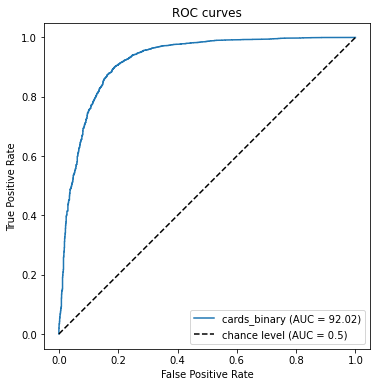

In [7]:
def add_binary_cards(data):
    data["cards_binary_pred"] = data["cards_pred"].apply(
        lambda x: 0 if x=="0_0" or x=='0.0' else 1)
    data["cards_binary_proba"] = data["cards_proba"].apply(lambda x: [x[0], sum(x[1:])])
    return data

def models_comparative(data, models):
    labels = [0, 1]
    target_names = ["Not Misinformation", "Misinformation"]
    freport = pd.DataFrame()
    
    plt.figure(figsize=(8, 6))
    for model in models:
        print(model)
        y_true = data.labels.values
        y_pred = data[f"{model}_pred"].values

        scores = data.apply(lambda x: 1-x[f"{model}_proba"][int(x[f"{model}_pred"])], axis=1).values
        fpr, tpr, thresholds = roc_curve(data.labels, scores)    
        roc_auc = auc(tpr, fpr)# multi_class="ovr", average="macro")
        plt.plot(tpr, fpr, label=f"{model} (AUC = {round(roc_auc*100, 2)})")

        acc = accuracy_score(y_true, y_pred)
        print(classification_report(y_true, y_pred, labels=labels))

        report = {
            "Model": model,
            "AUC": roc_auc,
            "Accuracy": accuracy_score(y_true, y_pred),
            "F1-score": f1_score(y_true, y_pred, average='macro')
        }   
        report = pd.DataFrame([report])
        freport = pd.concat([freport, report])
        freport = freport.sort_values(["AUC"])

    display(freport)

    plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
    plt.axis("square")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC curves")
    plt.legend()
    plt.show()
    
# models = ["roberta_cards_pipe", "roberta", "bertweet", "xlnet"]
display(Markdown(f"### Test Dataset"))
# models = ["roberta", "electra", "bertweet", "xlnet"]

test = data[data.PARTITION=="TEST"]
test = add_binary_cards(test)
# test.loc[test.cards_binary==0, "cards_binary"] = 0
models = ["cards_binary"]
models_comparative(test, models)

# def generated_dataset(file, models):
#     data = pd.read_csv(file, low_memory=False)
#     for model in models:
#         if model!="cards":
#             data[f"{model}_pred"] = data[f"{model}_pred"].apply(lambda x: int(float(x)))
#         data[f"{model}_proba"] = data[f"{model}_proba"].apply(format_scores)
#     data["labels"] = 1
#     return data

# ## Generated from the test partition
# test_generated = generated_dataset(
#     "datasets/generated_disinformation_binary_TEST_CHATGPT.csv", ["cards", "roberta", "aug_roberta"])
# test_generated = add_binary_cards(test_generated)
# display(Markdown(f"### Randomly Generated TEST CHATGPT"))
# models_comparative(test_generated, ["cards_binary", "roberta", "aug_roberta"])

# ## Generated from the ClimateScam partition
# climate_scam_generated = generated_dataset(
#     "datasets/generated_disinformation_binary_ClimateScam_CHATGPT.csv", ["cards", "roberta", "aug_roberta"])
# climate_scam_generated = add_binary_cards(climate_scam_generated)
# display(Markdown(f"### Randomly Generated Climate Scam CHATGPT"))
# models_comparative(climate_scam_generated, ["cards_binary", "roberta", "aug_roberta"])

## Roberta

Accuracy: 0.9017673653925196
AUC: 0.9138657198192381


,precision,recall,f1-score,support
Not Misinformation,0.927758,0.949217,0.938365,5750.000000
Misinformation,0.793785,0.725629,0.758179,1549.000000
accuracy,0.901767,0.901767,0.901767,0.901767
macro avg,0.860772,0.837423,0.848272,7299.000000
weighted avg,0.899326,0.901767,0.900126,7299.000000


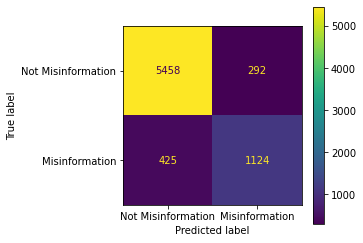

In [8]:
def report(y_true, y_pred, scores, classes, matrix_display=True):
    
    acc = accuracy_score(y_true, y_pred)
    
    scores = np.stack(scores.values)
    scores = scores[np.arange(scores.shape[0]), y_pred]
    
    fpr, tpr, thresholds = roc_curve(y_true, scores)    
    roc_auc = auc(tpr, fpr)# multi_class="ovr", average="macro")

    print(f"Accuracy: {acc}")
    print(f"AUC: {roc_auc}")
    
    if matrix_display:
        c_m = confusion_matrix(y_true, y_pred)
        cmp = ConfusionMatrixDisplay(
            c_m, display_labels=classes)
        fig, ax = plt.subplots(figsize=(4,4))
        cmp.plot(ax=ax)  
    
    report = pd.DataFrame(
        classification_report(y_true, y_pred, target_names=classes, output_dict=True)).transpose()
    
    display(report)
    
target_names = ["Not Misinformation", "Misinformation"]
# display(Markdown("**Waterloo-Cards**"))
# scores = test['roberta_proba'].apply(lambda x: sum(x))
# scores = test.apply(lambda x: x[f"{model}_proba"][x[f"{model}_pred"]], axis=1).values
report(test.labels, test['cards_pred'], test['cards_proba'], target_names)

Accuracy: 0.9635949943117179
AUC: 0.9003408170074838


,precision,recall,f1-score,support
Not Misinformation,0.979260,0.980731,0.979995,3996.000000
Misinformation,0.804071,0.791980,0.797980,399.000000
accuracy,0.963595,0.963595,0.963595,0.963595
macro avg,0.891666,0.886355,0.888987,4395.000000
weighted avg,0.963356,0.963595,0.963471,4395.000000


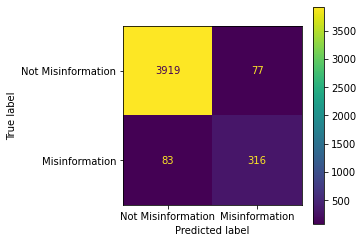

In [9]:
test_twitter = test[~test.tweetid.isna()]
scores = test_twitter['roberta_new_pipe_proba'].apply(lambda x: sum(x[1:]))
report(
    test_twitter.labels, test_twitter['roberta_new_pipe_pred'], 
    test_twitter['roberta_new_pipe_proba'], target_names
)

Accuracy: 0.903236914600551
AUC: 0.8224155966486539


,precision,recall,f1-score,support
Not Misinformation,0.900054,0.944698,0.921836,1754.000000
Misinformation,0.908749,0.840000,0.873023,1150.000000
accuracy,0.903237,0.903237,0.903237,0.903237
macro avg,0.904402,0.892349,0.897429,2904.000000
weighted avg,0.903497,0.903237,0.902506,2904.000000


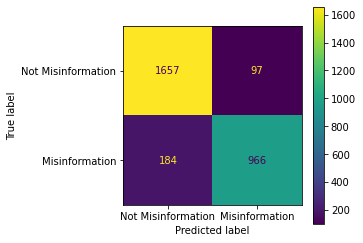

In [10]:
test_cards = test[test.tweetid.isna()]
# scores = test_cards['roberta_new_pipe_proba'].apply(lambda x: sum(x[1:]))
report(test_cards.labels, test_cards['roberta_new_pipe_pred'], 
       test_cards['roberta_new_pipe_proba'], target_names)

Accuracy: 0.9395807644882861
AUC: 0.8868555870547618


,precision,recall,f1-score,support
Not Misinformation,0.954304,0.969739,0.961960,5750.000000
Misinformation,0.880495,0.827631,0.853245,1549.000000
accuracy,0.939581,0.939581,0.939581,0.939581
macro avg,0.917399,0.898685,0.907602,7299.000000
weighted avg,0.938640,0.939581,0.938888,7299.000000


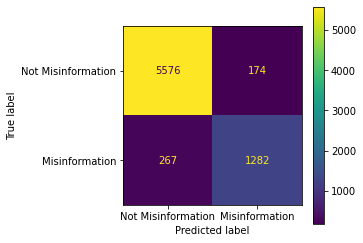

In [11]:
# scores = test['roberta_cards_pipe_proba'].apply(lambda x: sum(x[1:]))
report(test.labels, test['roberta_new_pipe_pred'], test['roberta_new_pipe_proba'], target_names)

## Bertweet

Accuracy: 0.935881627620222
AUC: 0.8900281808740562


,precision,recall,f1-score,support
Not Misinformation,0.950683,0.968870,0.959690,5750.000000
Misinformation,0.875608,0.813428,0.843373,1549.000000
accuracy,0.935882,0.935882,0.935882,0.935882
macro avg,0.913145,0.891149,0.901532,7299.000000
weighted avg,0.934750,0.935882,0.935005,7299.000000


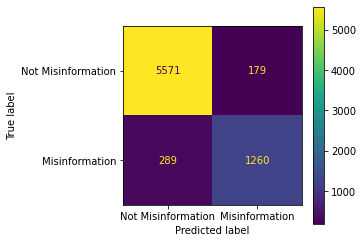

In [12]:
target_names = ["Not Misinformation", "Misinformation"]
# display(Markdown("**Waterloo-Cards**"))
scores = test['bertweet_proba'].apply(lambda x: sum(x[1:]))
report(test.labels, test['bertweet_pred'], test['bertweet_proba'], target_names)

Accuracy: 0.9620022753128555
AUC: 0.9098581664371139


,precision,recall,f1-score,support
Not Misinformation,0.977312,0.980981,0.979143,3996.000000
Misinformation,0.802083,0.771930,0.786718,399.000000
accuracy,0.962002,0.962002,0.962002,0.962002
macro avg,0.889698,0.876455,0.882931,4395.000000
weighted avg,0.961404,0.962002,0.961674,4395.000000


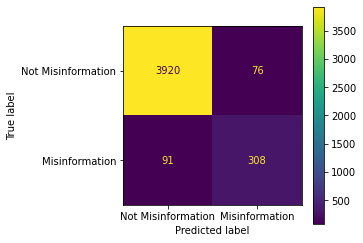

In [13]:
scores = test_twitter['bertweet_proba'].apply(lambda x: sum(x[1:]))
report(test_twitter.labels, test_twitter['bertweet_pred'], test_twitter['bertweet_proba'], target_names)

Accuracy: 0.8963498622589532
AUC: 0.8195406772098557


,precision,recall,f1-score,support
Not Misinformation,0.892915,0.941277,0.916459,1754.00000
Misinformation,0.902370,0.827826,0.863492,1150.00000
accuracy,0.896350,0.896350,0.896350,0.89635
macro avg,0.897642,0.884552,0.889975,2904.00000
weighted avg,0.896659,0.896350,0.895484,2904.00000


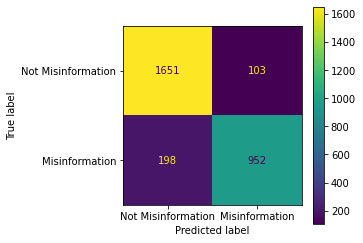

In [14]:
scores = test_cards['bertweet_proba'].apply(lambda x: sum(x[1:]))
report(test_cards.labels, test_cards['bertweet_pred'], test_cards['bertweet_proba'], target_names)

## Electra

In [15]:
data["PARTITION"].value_counts()

TRAIN    58590
TEST      7299
VALID     6999
Name: PARTITION, dtype: int64

In [16]:
test = data[data["PARTITION"] == "TEST"]

Accuracy: 0.9184819838334018
AUC: 0.8847436494793276


,precision,recall,f1-score,support
Not Misinformation,0.936347,0.961913,0.948958,5750.000000
Misinformation,0.842672,0.757263,0.797688,1549.000000
accuracy,0.918482,0.918482,0.918482,0.918482
macro avg,0.889510,0.859588,0.873323,7299.000000
weighted avg,0.916467,0.918482,0.916855,7299.000000


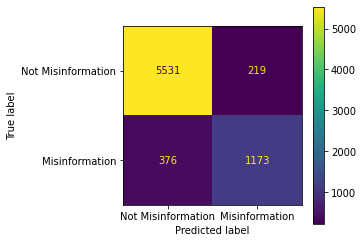

In [17]:
scores = test['electra_proba'].apply(lambda x: sum(x[1:]))
report(test.labels, test['electra_acc_pred'], test['electra_proba'], target_names)

## XLnet

Accuracy: 0.9335525414440334
AUC: 0.9015225531198249


,precision,recall,f1-score,support
Not Misinformation,0.948238,0.968522,0.958272,5750.000000
Misinformation,0.873072,0.803744,0.836975,1549.000000
accuracy,0.933553,0.933553,0.933553,0.933553
macro avg,0.910655,0.886133,0.897624,7299.000000
weighted avg,0.932286,0.933553,0.932531,7299.000000


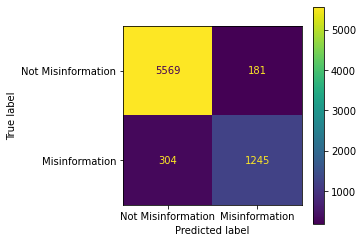

In [18]:
scores = test['xlnet_proba'].apply(lambda x: sum(x[1:]))
report(test.labels, test['xlnet_pred'], test['xlnet_proba'], target_names)

## GPT-3 Curie

In [19]:
filter_ = test['gpt-3_curie_pred'].isin(['0', '1'])
filter_.value_counts(normalize=True)

True     0.968078
False    0.031922
Name: gpt-3_curie_pred, dtype: float64

In [20]:
test_filtered = test[filter_]

Accuracy: 0.9506085479762242
AUC: 0.030599087971633895


,precision,recall,f1-score,support
Not Misinformation,0.951911,0.987262,0.969265,5574.000000
Misinformation,0.944747,0.813673,0.874325,1492.000000
accuracy,0.950609,0.950609,0.950609,0.950609
macro avg,0.948329,0.900468,0.921795,7066.000000
weighted avg,0.950399,0.950609,0.949218,7066.000000


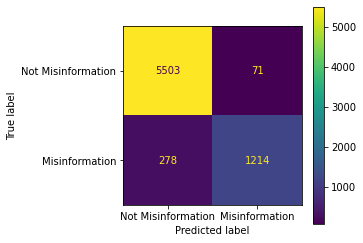

In [21]:
scores = test_filtered.apply(
    lambda x: [x['gpt-3_curie_proba'],1-x['gpt-3_curie_proba']] if ['gpt-3_curie_pred']==0 else [1-x['gpt-3_curie_proba'],x['gpt-3_curie_proba']], axis=1)
report(test_filtered.labels, test_filtered['gpt-3_curie_pred'].apply(int), 
       scores, target_names)

## Resume

In [22]:
test_cards = test[test.DATASET=="cards"]
test_waterloo = test[test.DATASET=="waterloo"]
index = ["CARDS", "Waterloo"]

models = ["roberta_new_pipe", "bertweet", "electra", "xlnet"]
datasets = [test_cards, test_waterloo]

comparative = pd.DataFrame()
for j, d in enumerate(datasets):
    scores = []
    for i, m in enumerate(models):
        score = f1_score(d["labels"], d[f"{m}_pred"], average="macro")
        scores.append(score)
    comparative = pd.concat([comparative, pd.Series(scores)], ignore_index=True, axis=1)
        
comparative = comparative.T
comparative.columns = ["RoBERTa", "BERTweet", "Electra", "XLnet"]
comparative.index = index
comparative["Support"] = test.DATASET.value_counts().tolist() #+ [inner_joinedsample.shape[0]]
comparative

,RoBERTa,BERTweet,Electra,XLnet,Support
CARDS,0.897429,0.889975,0.887220,0.889154,4395
Waterloo,0.888987,0.882931,0.860729,0.873174,2904


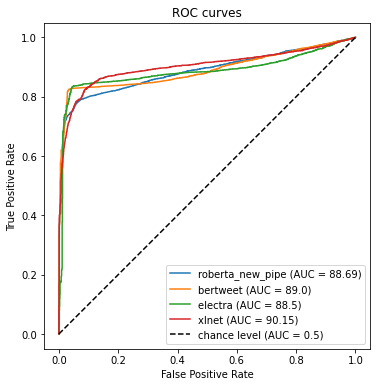

In [23]:
plt.figure(figsize=(8, 6))

y_true = test.labels.values

for model in models:
    y_pred = test[f"{model}_pred"].values

    scores = test.apply(lambda x: x[f"{model}_proba"][int(x[f"{model}_pred"])], axis=1).values
    fpr, tpr, thresholds = roc_curve(test.labels, scores)    
    roc_auc = auc(tpr, fpr)# multi_class="ovr", average="macro")
    plt.plot(tpr, fpr, label=f"{model} (AUC = {round(roc_auc*100, 2)})")


plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curves")
plt.legend()
plt.show()